# Parsing MIDI Files: Three Different Approaches

In this notebook, we'll explore three different Python libraries for working with MIDI files: 
1. **pretty_midi** - High-level interface focused on musical content
2. **mido** - Low-level interface for MIDI messages
3. **pypianoroll** - Piano roll representation for multi-track music

Each library offers different perspectives and use cases for symbolic music processing.

## Setup 
First, let's install the required libraries and import them:

`!pip install pretty_midi mido pypianoroll`


In [1]:
# Import all the libraries we'll use in the notebook
from collections import defaultdict
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import mido
import numpy as np
import pretty_midi
import pypianoroll

In [2]:
# Set up the dataset path
MIDI_DATASET_PATH = Path("../data/midi")

# Get a list of all MIDI files
midi_files = sorted(list(MIDI_DATASET_PATH.glob("*.mid")))  # Sorted for reproducibility
print(f"Found {len(midi_files)} MIDI files in the dataset")

# Let's use a known MIDI file for demonstration
example_file = MIDI_DATASET_PATH / "A_Kind_of_Magic.1.mid"
example_file_2 = MIDI_DATASET_PATH / "Baby_One_More_Time.4.mid"
print(f"\nUsing example MIDI files: \n1. {example_file.name}\n2. {example_file_2.name}")

Found 101 MIDI files in the dataset

Using example MIDI files: 
1. A_Kind_of_Magic.1.mid
2. Baby_One_More_Time.4.mid


## 1. `mido`: Low-Level MIDI Message Interface
 
`mido` works with raw MIDI messages, giving you complete control over the MIDI format.

 
**Documentation:** https://mido.readthedocs.io/en/latest/


In [3]:
# Load a MIDI file with mido
mid = mido.MidiFile(str(example_file))

# Basic information
print(f"File: {example_file.name}")
print(f"MIDI Type: {mid.type}")  # Can be 0, 1, 2
print(f"Number of tracks: {len(mid.tracks)}")  # Always 1 if type 0, greater if type 1,2
print(f"Ticks per beat: {mid.ticks_per_beat}")  # Also known as Pulses Per Quarter note
print(f"Total length: {mid.length:.2f} seconds")  # Returns playback time in seconds

File: A_Kind_of_Magic.1.mid
MIDI Type: 0
Number of tracks: 1
Ticks per beat: 384
Total length: 269.31 seconds


In [4]:
# iterate over the midi dataset and extract information about the files contained
midi_info = defaultdict(list)
for midi_file in midi_files:
    try:
        midi_data = mido.MidiFile(midi_file)
        # count how many files are of type 0, 1, or 2
        midi_info["type"].append(midi_data.type)
        # count how many tracks are in each file
        midi_info["num_tracks"].append(len(midi_data.tracks))
        # count how many ticks per beat are in each file
        midi_info["ticks_per_beat"].append(midi_data.ticks_per_beat)

    except Exception:
        continue

# Display summary statistics
for key, values in midi_info.items():
    unique, counts = np.unique(values, return_counts=True)
    print(f"\nSummary for {key}:")
    for u, c in zip(unique, counts):
        print(f"  {u}: {c} files")


Summary for type:
  0: 26 files
  1: 72 files

Summary for num_tracks:
  1: 27 files
  2: 1 files
  3: 4 files
  4: 1 files
  6: 3 files
  7: 3 files
  8: 5 files
  9: 4 files
  10: 2 files
  11: 7 files
  12: 8 files
  13: 10 files
  14: 3 files
  15: 1 files
  16: 4 files
  17: 6 files
  18: 2 files
  19: 1 files
  21: 1 files
  22: 1 files
  23: 1 files
  27: 2 files
  30: 1 files

Summary for ticks_per_beat:
  96: 7 files
  120: 11 files
  192: 20 files
  240: 3 files
  384: 46 files
  480: 11 files


### MIDI Messages in `mido`

In [5]:
# Show messages from the first track
print("\nFirst 20 messages from track 0:")
for i, msg in enumerate(mid.tracks[0][:20]):
    print(f"  {i}: {msg}")



First 20 messages from track 0:
  0: MetaMessage('track_name', name='A Kind Of', time=0)
  1: MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
  2: MetaMessage('set_tempo', tempo=458010, time=0)
  3: sysex data=(65,16,66,18,64,0,127,0,65) time=0
  4: control_change channel=0 control=0 value=0 time=384
  5: control_change channel=0 control=32 value=0 time=4
  6: program_change channel=0 program=52 time=4
  7: control_change channel=0 control=7 value=110 time=4
  8: control_change channel=0 control=10 value=104 time=0
  9: control_change channel=0 control=11 value=127 time=0
  10: control_change channel=0 control=91 value=127 time=4
  11: control_change channel=0 control=93 value=30 time=0
  12: control_change channel=1 control=0 value=0 time=4
  13: control_change channel=1 control=32 value=0 time=4
  14: program_change channel=1 program=33 time=4
  15: control_change channel=1 control=7 value=110 time=4
  16: control

In [6]:
# Count different message types across all tracks
message_types = {}
for track in mid.tracks:
    for msg in track:
        msg_type = msg.type
        message_types[msg_type] = message_types.get(msg_type, 0) + 1

print("Message type distribution:\n")
for msg_type, count in sorted(message_types.items(), key=lambda x: x[1], reverse=True):
    print(f"- {msg_type}: {count}")

Message type distribution:

- note_on: 4886
- note_off: 4886
- control_change: 2286
- pitchwheel: 1019
- program_change: 14
- time_signature: 2
- track_name: 1
- set_tempo: 1
- sysex: 1
- end_of_track: 1


In [7]:
# Count number of different event types, i.e. meta, sysex, and regular MIDI messages
message_types = {}
for track in mid.tracks:
    for msg in track:
        if msg.is_meta:
            msg_type = "meta"
        elif msg.type == "sysex":
            msg_type = "sysex"
        else:
            msg_type = "track"
        message_types[msg_type] = message_types.get(msg_type, 0) + 1

print("Message type distribution:\n")
for msg_type, count in sorted(message_types.items(), key=lambda x: x[1], reverse=True):
    print(f"- {msg_type}: {count}")


Message type distribution:

- track: 13091
- meta: 5
- sysex: 1


In [8]:
# Check whether messages are meta, sysex, or track events
print("\nFirst 20 messages from track 0 with type classification:")
for i, msg in enumerate(mid.tracks[0][:20]):
    # Check if it's a meta message
    if msg.is_meta:
        print(f"{i}: [META] {msg}")
    elif msg.type == "sysex":
        print(f"{i}: [SYSEX] {msg}")
    else:
        print(f"{i}: [TRACK] {msg}")


First 20 messages from track 0 with type classification:
0: [META] MetaMessage('track_name', name='A Kind Of', time=0)
1: [META] MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
2: [META] MetaMessage('set_tempo', tempo=458010, time=0)
3: [SYSEX] sysex data=(65,16,66,18,64,0,127,0,65) time=0
4: [TRACK] control_change channel=0 control=0 value=0 time=384
5: [TRACK] control_change channel=0 control=32 value=0 time=4
6: [TRACK] program_change channel=0 program=52 time=4
7: [TRACK] control_change channel=0 control=7 value=110 time=4
8: [TRACK] control_change channel=0 control=10 value=104 time=0
9: [TRACK] control_change channel=0 control=11 value=127 time=0
10: [TRACK] control_change channel=0 control=91 value=127 time=4
11: [TRACK] control_change channel=0 control=93 value=30 time=0
12: [TRACK] control_change channel=1 control=0 value=0 time=4
13: [TRACK] control_change channel=1 control=32 value=0 time=4
14: [TRACK] pr

In [9]:
# Comprehensive meta event extraction
all_meta_events = defaultdict(list)

for i, track in enumerate(mid.tracks):
    for msg in track:
        if msg.is_meta:
            all_meta_events[msg.type].append({
                "track": i,
                "time": msg.time,
                "data": msg.dict(),  # Get all message attributes
            })

print("\nAll meta events in file:")
for meta_type, events in all_meta_events.items():
    print(f"\n{meta_type}: {len(events)} occurrence(s)")
    for event in events[:3]:  # Show first 3
        print(f"  Track {event['track']}, tick {event['time']}: {event['data']}")


All meta events in file:

track_name: 1 occurrence(s)
  Track 0, tick 0: {'type': 'track_name', 'name': 'A Kind Of', 'time': 0}

time_signature: 2 occurrence(s)
  Track 0, tick 0: {'type': 'time_signature', 'numerator': 4, 'denominator': 4, 'clocks_per_click': 24, 'notated_32nd_notes_per_beat': 8, 'time': 0}
  Track 0, tick 876: {'type': 'time_signature', 'numerator': 4, 'denominator': 4, 'clocks_per_click': 24, 'notated_32nd_notes_per_beat': 8, 'time': 876}

set_tempo: 1 occurrence(s)
  Track 0, tick 0: {'type': 'set_tempo', 'tempo': 458010, 'time': 0}

end_of_track: 1 occurrence(s)
  Track 0, tick 1536: {'type': 'end_of_track', 'time': 1536}


### Understanding MIDI Time in `mido`

In [10]:
# Store metadata information, i.e. time signature, tempo changes
metadata = {
    "time_signatures": [],
    "tempos": [],
}
for track in mid.tracks:
    for msg in track:
        if msg.type == "time_signature":
            metadata["time_signatures"].append((
                f"{msg.numerator}/{msg.denominator}",
                msg.time,
            ))
        elif msg.type == "set_tempo":
            metadata["tempos"].append((
                msg.tempo,
                msg.time,
            ))
print("\nMetadata extracted:")
for key, items in metadata.items():
    print(f"- {key}: {items}")


Metadata extracted:
- time_signatures: [('4/4', 0), ('4/4', 876)]
- tempos: [(458010, 0)]


In [11]:
# Convert the tempo manually to BPM

# Since the tempo is given in microseconds per beat, we convert it to BPM as follows:
# 6000000 / microseconds_per_beat = BPM
microseconds_per_quarter = metadata["tempos"][0][0]


def tempo_to_bpm(microseconds_per_quarter) -> float:
    """
    Convert tempo from microseconds per beat to BPM.
    """
    return 60000000 / microseconds_per_quarter


bpm = tempo_to_bpm(microseconds_per_quarter)
print(
    f"\nTempo: {microseconds_per_quarter} microseconds per quarter note = {bpm:.2f} BPM"
)


Tempo: 458010 microseconds per quarter note = 131.00 BPM


In [12]:
# Convert tempo automatically using mido
bpm_auto = mido.tempo2bpm(microseconds_per_quarter)
print(f"Tempo (using mido): {bpm_auto:.2f} BPM")

Tempo (using mido): 131.00 BPM


In [13]:
def ticks_to_seconds(ticks, tempo, ticks_per_beat):
    """Convert MIDI ticks to seconds

    Args:
        ticks: number of ticks
        tempo: microseconds per quarter note
        ticks_per_beat: from mid.ticks_per_beat
    """
    return (ticks * tempo) / (ticks_per_beat * 1_000_000)


ticks_per_beat = mid.ticks_per_beat

# Let's get the file length in ticks
# In order to do this, we need to sum up the delta times of all messages in all tracks
oot_time = 0
for track in mid.tracks:
    track_time = sum(msg.time for msg in track)
    if track_time > oot_time:
        oot_time = track_time


# get the time in seconds
seconds = ticks_to_seconds(
    oot_time,
    microseconds_per_quarter,  # From previous code cell
    ticks_per_beat,
)
seconds

269.30988

### Handling Note Events in `mido`

In [14]:
def extract_notes_from_mido(midi_path):
    """Extract note events with timing information"""
    mid = mido.MidiFile(str(midi_path))

    notes = []
    for track_idx, track in enumerate(mid.tracks):
        current_time = 0
        active_notes = {}  # pitch -> start_time

        for msg in track:
            current_time += msg.time

            if msg.type == "note_on" and msg.velocity > 0:
                # Note starts
                active_notes[msg.note] = {
                    "start": current_time,
                    "velocity": msg.velocity,
                    "channel": msg.channel,
                }
            elif msg.type == "note_off" or (
                msg.type == "note_on" and msg.velocity == 0
            ):
                # Note ends
                if msg.note in active_notes:
                    note_info = active_notes.pop(msg.note)
                    notes.append({
                        "track": track_idx,
                        "pitch": msg.note,
                        "start": note_info["start"],
                        "end": current_time,
                        "duration": current_time - note_info["start"],
                        "velocity": note_info["velocity"],
                        "channel": note_info["channel"],
                    })

    return notes


# Extract notes
notes = extract_notes_from_mido(example_file)
print(f"\nExtracted {len(notes)} notes from {example_file.name}")

if notes:
    print("\nFirst 20 notes:")
    for note in notes[:20]:
        note_name = pretty_midi.note_number_to_name(note["pitch"])
        print(
            f"  Pitch: {note['pitch']} ({note_name}), "
            f"Start: {note['start']:.2f}, Duration: {note['duration']:.2f}, "
            f"Velocity: {note['velocity']}, Track: {note['track']}"
        )



Extracted 4527 notes from A_Kind_of_Magic.1.mid

First 20 notes:
  Pitch: 57 (A3), Start: 1536.00, Duration: 68.00, Velocity: 101, Track: 0
  Pitch: 57 (A3), Start: 1728.00, Duration: 96.00, Velocity: 112, Track: 0
  Pitch: 54 (F#3), Start: 1920.00, Duration: 184.00, Velocity: 101, Track: 0
  Pitch: 52 (E3), Start: 2112.00, Duration: 112.00, Velocity: 89, Track: 0
  Pitch: 57 (A3), Start: 2304.00, Duration: 332.00, Velocity: 112, Track: 0
  Pitch: 54 (F#3), Start: 2688.00, Duration: 464.00, Velocity: 101, Track: 0
  Pitch: 57 (A3), Start: 4608.00, Duration: 48.00, Velocity: 97, Track: 0
  Pitch: 57 (A3), Start: 4800.00, Duration: 124.00, Velocity: 112, Track: 0
  Pitch: 54 (F#3), Start: 4992.00, Duration: 160.00, Velocity: 93, Track: 0
  Pitch: 52 (E3), Start: 5184.00, Duration: 120.00, Velocity: 89, Track: 0
  Pitch: 57 (A3), Start: 5376.00, Duration: 300.00, Velocity: 97, Track: 0
  Pitch: 61 (C#4), Start: 5760.00, Duration: 480.00, Velocity: 97, Track: 0
  Pitch: 57 (A3), Start: 78

### Processing a MIDI Type 1 File in `mido`

In [15]:
# Load a type 1 MIDI file with mido
mid1 = mido.MidiFile(str(example_file_2))

# Basic information
print(f"File: {example_file_2.name}")
print(f"MIDI Type: {mid1.type}")  # Can be 0, 1, 2
print(
    f"Number of tracks: {len(mid1.tracks)}"
)  # Always 1 if type 0, greater if type 1,2
print(f"Ticks per beat: {mid1.ticks_per_beat}")  # Also known as Pulses Per Quarter note
print(f"Total length: {mid1.length:.2f} seconds")  # Returns playback time in seconds

File: Baby_One_More_Time.4.mid
MIDI Type: 1
Number of tracks: 17
Ticks per beat: 480
Total length: 211.20 seconds


In [16]:
# Count different message types across all tracks
message_types1 = {}
for track in mid1.tracks:
    for msg in track:
        msg_type = msg.type
        message_types1[msg_type] = message_types1.get(msg_type, 0) + 1

print("Message type distribution:\n")
for msg_type, count in sorted(message_types1.items(), key=lambda x: x[1], reverse=True):
    print(f"- {msg_type}: {count}")

Message type distribution:

- note_on: 2558
- note_off: 2555
- control_change: 491
- pitchwheel: 443
- end_of_track: 17
- midi_port: 16
- channel_prefix: 16
- program_change: 16
- track_name: 7
- sysex: 5
- copyright: 1
- set_tempo: 1
- time_signature: 1
- key_signature: 1


In [17]:
# Access the events in the first track
print("\nFirst 20 messages from track 0:")
for i, msg in enumerate(mid1.tracks[0][:20]):
    print(f"  {i}: {msg}")


First 20 messages from track 0:
  0: sysex data=(126,127,9,1) time=0
  1: sysex data=(65,16,66,18,64,0,127,0,65) time=0
  2: sysex data=(65,16,66,18,64,1,52,95,44) time=0
  3: sysex data=(65,16,66,18,64,1,55,20,116) time=0
  4: sysex data=(65,16,66,18,64,1,51,26,114) time=0
  5: MetaMessage('track_name', name='Baby One More Time', time=0)
  6: MetaMessage('copyright', text='Copyright © 1999 by TOPLIST TEAM. Excl. for Fox Music', time=0)
  7: MetaMessage('set_tempo', tempo=324324, time=0)
  8: MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
  9: MetaMessage('key_signature', key='C', time=0)
  10: MetaMessage('end_of_track', time=0)


In [18]:
# Print first 20 messages from track 1
print("\nFirst 20 messages from track 1:")
for i, msg in enumerate(mid1.tracks[1][:20]):
    print(f"  {i}: {msg}")


First 20 messages from track 1:
  0: MetaMessage('track_name', name='Britney Spears', time=0)
  1: MetaMessage('midi_port', port=0, time=0)
  2: MetaMessage('channel_prefix', channel=0, time=0)
  3: control_change channel=0 control=10 value=64 time=0
  4: control_change channel=0 control=11 value=127 time=360
  5: control_change channel=0 control=91 value=50 time=8
  6: control_change channel=0 control=93 value=0 time=8
  7: control_change channel=0 control=94 value=0 time=8
  8: control_change channel=0 control=0 value=0 time=96
  9: control_change channel=0 control=32 value=1 time=4
  10: program_change channel=0 program=1 time=4
  11: control_change channel=0 control=7 value=92 time=4
  12: control_change channel=0 control=10 value=64 time=0
  13: note_on channel=0 note=46 velocity=120 time=1908
  14: note_on channel=0 note=34 velocity=127 time=0
  15: note_on channel=0 note=58 velocity=120 time=0
  16: note_off channel=0 note=58 velocity=64 time=452
  17: note_off channel=0 note=3

### Creating a new MIDI File with `mido`

In [19]:
# Create a simple C major scale
new_mid = mido.MidiFile()
track = mido.MidiTrack()
new_mid.tracks.append(track)

# Add track name and tempo
track.append(mido.MetaMessage("track_name", name="C Major Scale", time=0))
track.append(mido.MetaMessage("set_tempo", tempo=500000, time=0))  # 120 BPM

# C major scale: C, D, E, F, G, A, B, C
c_major_scale = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note numbers

# Add notes (quarter notes at 480 ticks per beat)
ticks_per_quarter = 480
for note_num in c_major_scale:
    track.append(mido.Message("note_on", note=note_num, velocity=64, time=0))
    track.append(
        mido.Message("note_off", note=note_num, velocity=64, time=ticks_per_quarter)
    )

# Save the file
output_path = MIDI_DATASET_PATH / "c_major_scale.mid"
new_mid.save(str(output_path))
print(f"Created new MIDI file: {output_path}")

Created new MIDI file: ../data/midi/c_major_scale.mid


## 2. pretty_midi: High-Level Musical Interface

`pretty_midi` provides an intuitive, object-oriented interface focused on musical concepts like notes, instruments, and tempo.

**Documentation:** https://craffel.github.io/pretty-midi/

In [20]:
mid_pm = pretty_midi.PrettyMIDI(str(example_file))
print("\nPRETTY_MIDI Representation:")
print(f"- Resolution: {mid_pm.resolution}")
print(f"- Instruments: {len(mid_pm.instruments)}")
print(f"- Tempo: {mid_pm.get_tempo_changes()[1][0]} BPM")
print(f"- Duration: {mid_pm.get_end_time():.2f} seconds")


PRETTY_MIDI Representation:
- Resolution: 384
- Instruments: 14
- Tempo: 131.0015065173249 BPM
- Duration: 267.48 seconds


### Instrument-Based Organization in `pretty_midi` 

In [21]:
# pretty_midi allows to access instruments directly, rather than accessing messages

# get all instruments from the midi file
midi_pm_instruments = mid_pm.instruments
print(f"Number of instruments: {len(midi_pm_instruments)}")

for i, instrument in enumerate(midi_pm_instruments):
    # get the program number of the instrument
    instrument_program = instrument.program
    # get the program name associated with the program number
    program_name = pretty_midi.program_to_instrument_name(instrument.program)
    # check if the program is a drum
    instrument_is_drum = instrument.is_drum
    # get the list of notes associated with the instrument
    instrument_notes = instrument.notes
    # get the list of control changes associated with the instrument
    instrument_control_changes = instrument.control_changes
    # get the list of pitch bends associated with the instrument
    instrument_pitch_bends = instrument.pitch_bends

    print(f"\nInstrument {i}")
    print(f"- Program number: {instrument_program}")
    print(f"- Program name: {program_name}")
    print(f"- Is drum: {instrument_is_drum}")
    print(f"- Number of notes: {len(instrument_notes)}")
    print(f"- Number of control changes: {len(instrument_control_changes)}")
    print(f"- Number of pitch bends: {len(instrument_pitch_bends)}")

Number of instruments: 14

Instrument 0
- Program number: 65
- Program name: Alto Sax
- Is drum: False
- Number of notes: 248
- Number of control changes: 1347
- Number of pitch bends: 92

Instrument 1
- Program number: 101
- Program name: FX 6 (goblins)
- Is drum: False
- Number of notes: 10
- Number of control changes: 308
- Number of pitch bends: 0

Instrument 2
- Program number: 0
- Program name: Acoustic Grand Piano
- Is drum: True
- Number of notes: 2633
- Number of control changes: 84
- Number of pitch bends: 0

Instrument 3
- Program number: 51
- Program name: Synth Strings 2
- Is drum: False
- Number of notes: 211
- Number of control changes: 84
- Number of pitch bends: 0

Instrument 4
- Program number: 62
- Program name: Synth Brass 1
- Is drum: False
- Number of notes: 61
- Number of control changes: 10
- Number of pitch bends: 43

Instrument 5
- Program number: 33
- Program name: Electric Bass (finger)
- Is drum: False
- Number of notes: 905
- Number of control changes: 84


### Note Objects and Time in `pretty_midi`

In [22]:
# pretty_midi allows to access notes directly, rather than accessing messages
# and extract information from them

# get notes from instrument 3
instrtument_3 = midi_pm_instruments[3]

# print (again) how many notes are contained in the instrument, the program number and name
print(
    f"Instrument 3 has {len(instrtument_3.notes)} notes, played by "
    f"{pretty_midi.program_to_instrument_name(instrtument_3.program)}"
)

# pretty_midi Note objects have several attributes
print("\nFirst 10 notes from Instrument 3:")
for i, note in enumerate(instrtument_3.notes[:10]):
    print(
        f"Note {i}: Pitch: {note.pitch} "
        # there's an utility function to convert MIDI note numbers to names
        f"({pretty_midi.note_number_to_name(note.pitch)}"
        # and also an utility to convert MIDI notes to frequencies
        f"-{pretty_midi.note_number_to_hz(note.pitch):.2f} Hz), "
        # times and durations are in seconds!
        f"Start: {note.start:.2f}, End: {note.end:.2f}, Duration: {note.end - note.start:.2f}, "
        f"Velocity: {note.velocity}"
    )

Instrument 3 has 211 notes, played by Synth Strings 2

First 10 notes from Instrument 3:
Note 0: Pitch: 57 (A3-220.00 Hz), Start: 12.80, End: 16.46, Duration: 3.66, Velocity: 34
Note 1: Pitch: 52 (E3-164.81 Hz), Start: 12.80, End: 16.46, Duration: 3.66, Velocity: 34
Note 2: Pitch: 45 (A2-110.00 Hz), Start: 12.80, End: 16.46, Duration: 3.66, Velocity: 34
Note 3: Pitch: 59 (B3-246.94 Hz), Start: 16.46, End: 20.13, Duration: 3.66, Velocity: 34
Note 4: Pitch: 54 (F#3-185.00 Hz), Start: 16.46, End: 20.13, Duration: 3.66, Velocity: 34
Note 5: Pitch: 47 (B2-123.47 Hz), Start: 16.46, End: 20.13, Duration: 3.66, Velocity: 34
Note 6: Pitch: 66 (F#4-369.99 Hz), Start: 20.13, End: 23.79, Duration: 3.66, Velocity: 34
Note 7: Pitch: 57 (A3-220.00 Hz), Start: 20.13, End: 23.79, Duration: 3.66, Velocity: 34
Note 8: Pitch: 50 (D3-146.83 Hz), Start: 20.13, End: 23.79, Duration: 3.66, Velocity: 34
Note 9: Pitch: 64 (E4-329.63 Hz), Start: 23.79, End: 27.46, Duration: 3.66, Velocity: 34


### Extracting Statistics with `pretty_midi`

In [23]:
def analyze_midi_with_pretty_midi(midi_path) -> dict[str, int | float]:
    """Extract various musical features from a MIDI file"""
    pm = pretty_midi.PrettyMIDI(str(midi_path))

    features = {
        "duration": pm.get_end_time(),
        "num_instruments": len(pm.instruments),
        "tempo_changes": len(pm.get_tempo_changes()[0]),
        "time_signature_changes": len(pm.time_signature_changes),
    }

    # Aggregate note information across all instruments
    all_notes = []
    for instrument in pm.instruments:
        if not instrument.is_drum:
            all_notes.extend(instrument.notes)

    if all_notes:
        features["num_notes"] = len(all_notes)
        features["pitch_range"] = max(n.pitch for n in all_notes) - min(
            n.pitch for n in all_notes
        )
        features["mean_velocity"] = np.mean([n.velocity for n in all_notes])
        features["note_density"] = (
            len(all_notes) / pm.get_end_time()
        )  # notes per second

    return features


# Analyze all MIDI files
print("Analyzing all MIDI files in dataset:")
for midi_file in midi_files[:5]:  # Show first 5
    features = analyze_midi_with_pretty_midi(midi_file)
    print(f"\n{midi_file.name}:")
    for key, value in features.items():
        print(
            f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}"
        )


Analyzing all MIDI files in dataset:



A_Kind_of_Magic.1.mid:
  duration: 267.48
  num_instruments: 14
  tempo_changes: 1
  time_signature_changes: 2
  num_notes: 2253
  pitch_range: 55
  mean_velocity: 82.20
  note_density: 8.42

A_New_Day_Yesterday.mid:
  duration: 246.26
  num_instruments: 9
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 2685
  pitch_range: 60
  mean_velocity: 90.87
  note_density: 10.90

Again.mid:
  duration: 286.08
  num_instruments: 12
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 3638
  pitch_range: 54
  mean_velocity: 95.64
  note_density: 12.72

All_Along_the_Watchtower.mid:
  duration: 239.83
  num_instruments: 13
  tempo_changes: 1
  time_signature_changes: 1
  num_notes: 2549
  pitch_range: 40
  mean_velocity: 83.64
  note_density: 10.63

All_Apologies.3.mid:
  duration: 221.05
  num_instruments: 6
  tempo_changes: 1
  time_signature_changes: 2
  num_notes: 1957
  pitch_range: 43
  mean_velocity: 100.48
  note_density: 8.85


### Viualizing MIDI with `pretty_midi`


Piano roll shape: (128, 26747) == (128 pitches x time frames)


/tmp/ipykernel_1405782/523141256.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(


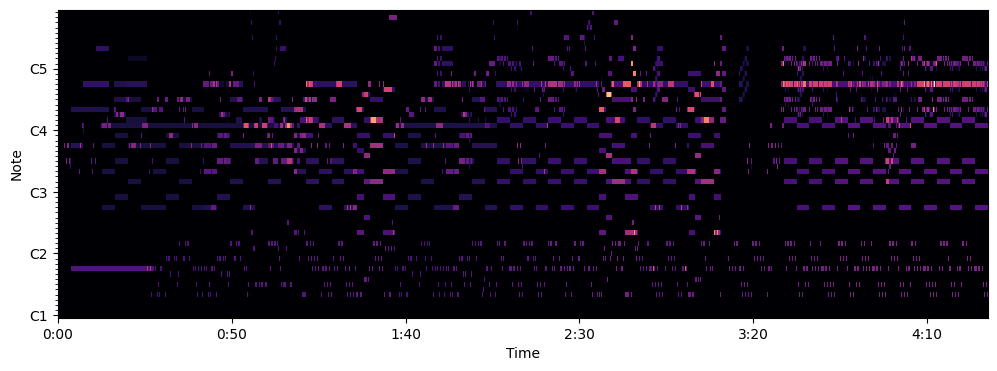

In [24]:
def plot_piano_roll(piano_roll, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(
        piano_roll[start_pitch:end_pitch],
        hop_length=1,
        sr=fs,
        x_axis="time",
        y_axis="cqt_note",
        fmin=pretty_midi.note_number_to_hz(start_pitch),
    )


# pretty_midi allows to convert the midi file to a piano roll representation
piano_roll = mid_pm.get_piano_roll(fs=100)
print(f"\nPiano roll shape: {piano_roll.shape} == (128 pitches x time frames)")

# define the figure size
plt.figure(figsize=(12, 4))
plot_piano_roll(piano_roll, 24, 84)

## 3. pypianoroll: Multi-Track Piano Roll Representation
 
`pypianoroll` represents music as piano rolls, which is particularly useful for deep learning applications.
 
**Documentation:** https://pypianoroll.readthedocs.io/en/latest/

In [25]:
# Load a MIDI file with pypianoroll
multitrack = pypianoroll.read(str(example_file_2))

# Basic info
print(f"\nResolution: {multitrack.resolution} ticks per beat")
print(f"Tracks: {len(multitrack.tracks)}")

# Track details
for i, track in enumerate(multitrack.tracks):
    print(f"\nTrack {i}: {track.name or 'Unnamed'}")
    print(f"  Program: {track.program}, Drum: {track.is_drum}")
    print(f"  Piano roll shape: {track.pianoroll.shape}")



Resolution: 24 ticks per beat
Tracks: 16

Track 0: Britney Spears
  Program: 1, Drum: False
  Piano roll shape: (15648, 128)

Track 1: Baby one more time
  Program: 33, Drum: False
  Piano roll shape: (15648, 128)

Track 2: Unnamed
  Program: 48, Drum: False
  Piano roll shape: (15648, 128)

Track 3: Sequenced by TOPLIST TEAM
  Program: 62, Drum: False
  Piano roll shape: (15648, 128)

Track 4: By Joop Wiersma & Kim Winther
  Program: 36, Drum: False
  Piano roll shape: (15648, 128)

Track 5: Unnamed
  Program: 53, Drum: False
  Piano roll shape: (15648, 128)

Track 6: Our website: http://www.foxmusic.nl/midi/
  Program: 55, Drum: False
  Piano roll shape: (15648, 128)

Track 7: E-mail: toplist@foxmusic.nl
  Program: 62, Drum: False
  Piano roll shape: (15648, 128)

Track 8: Unnamed
  Program: 89, Drum: False
  Piano roll shape: (15648, 128)

Track 9: Unnamed
  Program: 0, Drum: True
  Piano roll shape: (15648, 128)

Track 10: Unnamed
  Program: 35, Drum: False
  Piano roll shape: (15

In [26]:
# pypianoroll natively supports conversion with pretty_midi

# Convert PrettyMIDI to Pypianoroll
multitrack_from_pm = pypianoroll.from_pretty_midi(mid_pm, resolution=24)
print(
    f"Converted {len(mid_pm.instruments)} instruments to {len(multitrack_from_pm.tracks)} tracks"
)

# Convert Pypianoroll to PrettyMIDI
pm_from_multitrack = multitrack.to_pretty_midi()
print(
    f"Converted {len(multitrack.tracks)} tracks to {len(pm_from_multitrack.instruments)} instruments"
)

Converted 14 instruments to 14 tracks
Converted 16 tracks to 16 instruments


### Visualizing MIDI with `pypianoroll`

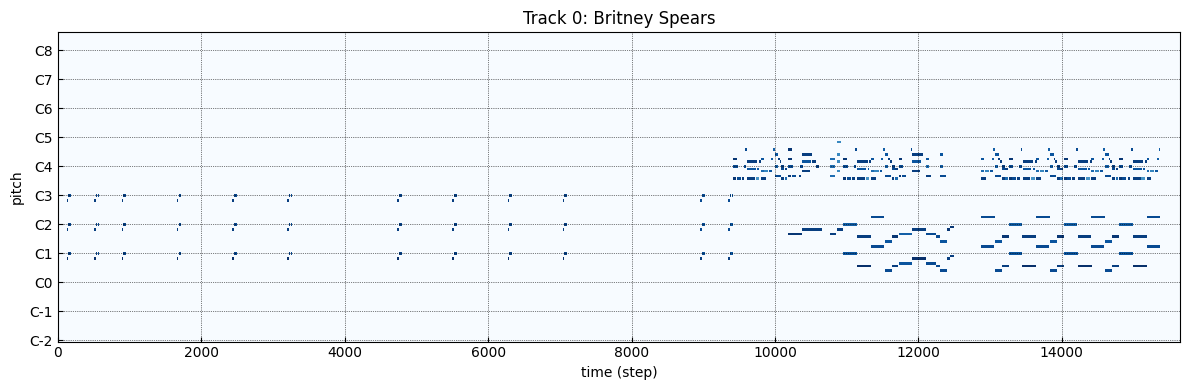

In [27]:
# Visualizing a single track piano roll
fig, ax = plt.subplots(figsize=(12, 4))
pypianoroll.plot_track(multitrack.tracks[0], ax=ax, cmap="Blues")
ax.set_title(f"Track 0: {multitrack.tracks[0].name or 'Unnamed'}")
plt.tight_layout()
plt.show()

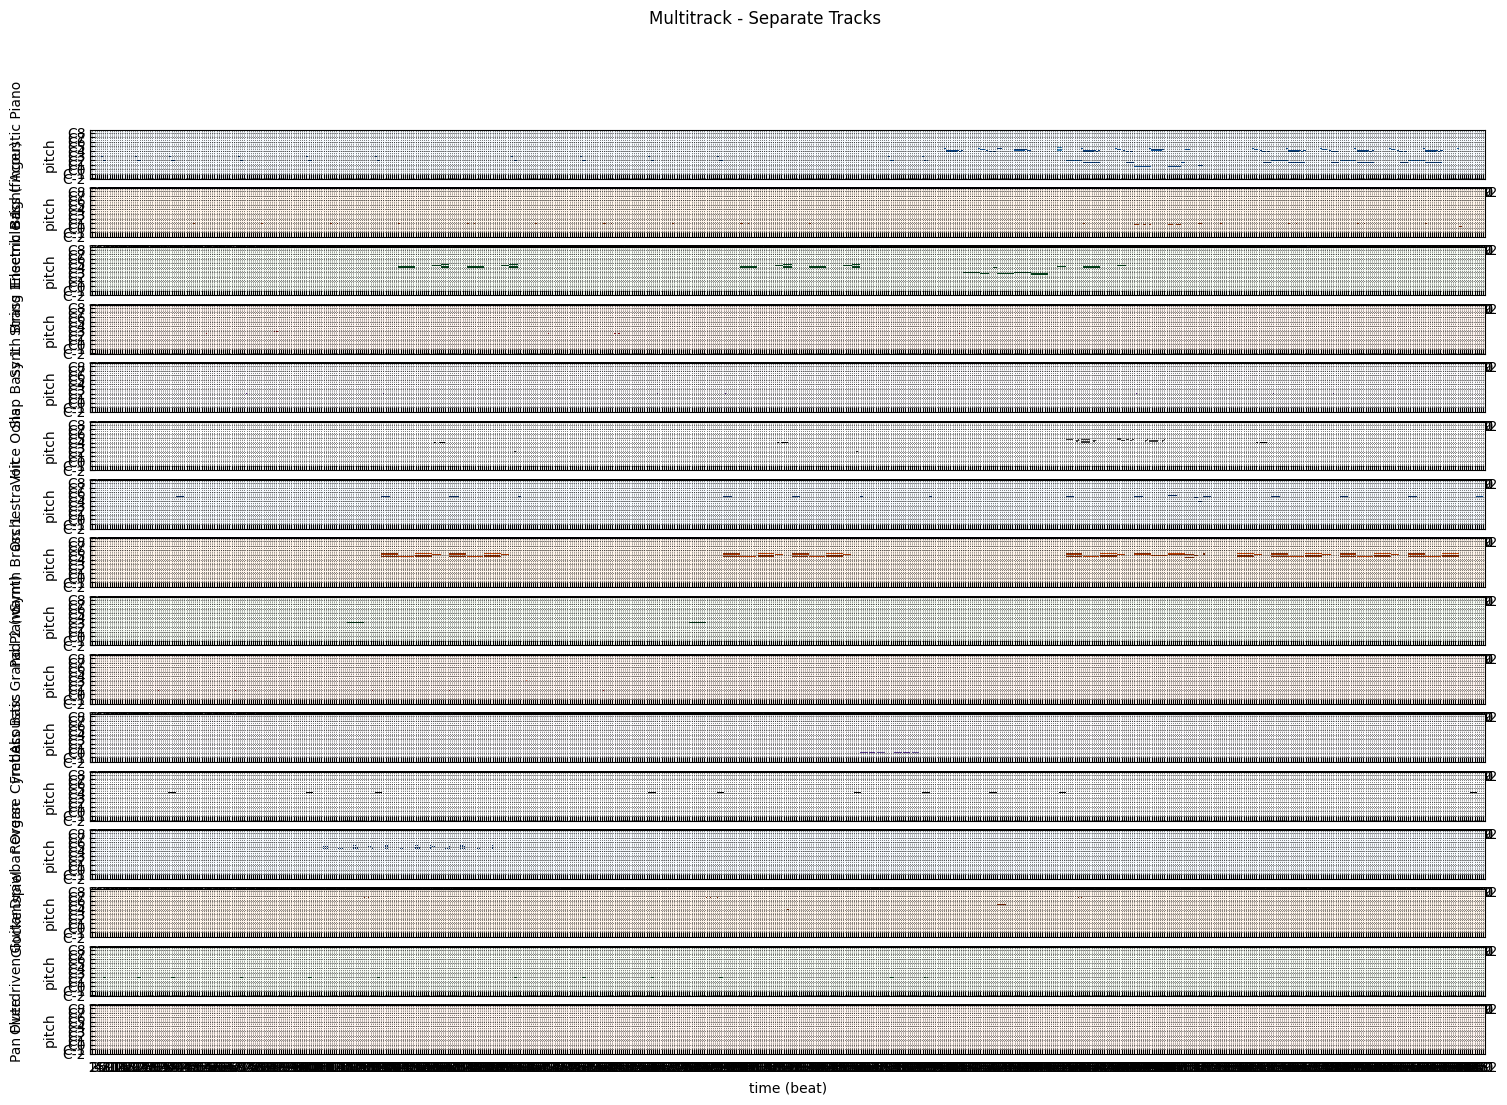

In [ ]:
# Vizualizing the multitrack piano roll with separate subplots
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(18, 12))
pypianoroll.plot_multitrack(multitrack, axs=axs, mode="separate", track_label="program")
plt.suptitle("Multitrack - Separate Tracks", y=0.98)
plt.show()

### Extract Metrics with `pypianoroll`

In [29]:
# Get first non-drum track
track = [t for t in multitrack.tracks if not t.is_drum][0]
pianoroll = track.pianoroll

print(f"Track: {track.name or 'Unnamed'}")
print(f"Unique pitches: {pypianoroll.n_pitches_used(pianoroll)}")
print(f"Unique pitch classes: {pypianoroll.n_pitch_classes_used(pianoroll)}/12")
print(f"Pitch range: {pypianoroll.pitch_range(pianoroll)} semitones")

Track: Britney Spears
Unique pitches: 26
Unique pitch classes: 7/12
Pitch range: 53 semitones


In [30]:
empty_beat = pypianoroll.empty_beat_rate(pianoroll, multitrack.resolution)
polyphonic = pypianoroll.polyphonic_rate(pianoroll)

print(f"Empty beat rate: {empty_beat:.2%}")
print(f"Polyphonic rate: {polyphonic:.2%}")

Empty beat rate: 40.49%
Polyphonic rate: 30.26%
